# Simulation of RCT EMS v3

Three scenarios: 

1. weekday
- weekend
- weekend with disaster

Three dispatch policies for ambulance selection: 
1. fastest ambulance 
- least coverage disruption
- optimal by weighting travel time and coverage

Nine total simulations, each compared. 

# Case count distributions

Each simulation has 100 cases regardless of how the scenarios will play out. This should mean that the disaster scenario will finish 100 cases in less time because there is a disaster time slot where many cases occur. We want to see if this is the case by comparing the disaster scenarios against the weekday and weekend scenarios. The dispatch policy might affect the distributions, but probably not be too much. 

# Cases reached before r1: 10 minutes

Since previous RCT studies looked at using the US EMS Act as the standard, we want to know how many cases are reached before the 10 minute requirement. If this is not reached, it's still helpful to know if the case was reached before the 14 minute secondary coverage requirement. 

Since Pons stated 8 minutes is the time when statistics actually found significant difference in case effectiveness, it may be useful to count the cases reached before 8 minutes. 

# Double coverage 

Plot the double coverage of the simulated RCTs over time. Here, the dispatch policy is important, and the specific scenarios may or may not make a difference. We expect to see best travel to do the worst, but weighted should have similar shape with best travel time despite being a little better. 

<hr/>

In [1]:
# Use matplotlib to graph and not bokeh (learn curve). 
# No command line magic, only analysis. 

# %matplotlib notebook
import matplotlib.pyplot as plt

import pandas
import scipy.stats as stats
from scipy.interpolate import make_interp_spline, BSpline
import numpy as np
from numpy import median, mean


from datetime import datetime, timedelta

from functools import reduce
from collections import Counter

<hr/>

#       READ DATA INTO THE NOTEBOOK:

In [2]:
csvs = [ # Every simulation produces these files.
    "chosen_ambulances.csv",
    "chosen_bases.csv",
    "chosen_hospitals.csv",
    "metrics.csv",
    "processed_cases.csv",
]

scenarios = [ # Three scenarios, two from the RCT, one additional contributed scenario 
    "weekday",
    "weekend",
    "disaster", # Note that the base scenario is weekend with a disaster intejected inside
]

policies = [ # Three ambulance dispatch policies were tested 
    "best-travel",
    "best-coverage",
    "weighted-dispatch",
]

result_directories = [ # This notebook is assumed to be in the home project repository directory. 
    "tj-{scenario}-{policy}/".format(scenario=scenario, policy=policy) \
    for scenario in scenarios for policy in policies
]

data_files = [
    directory + csv \
    for directory in result_directories for csv in csvs
]

# Test the filenames and counts formed correctly

# for r in result_directories: print(r) 
# print(len(result_directories))

# for f in data_files: print(f) 
# print(len(data_files))


def read_folder(data_files):
    
    """
    For each folder (simulation), read in their csv results
    
    data_files: a list of strs pointing to each csv file in the results
    returns: a dict(k: scenario, policy, data_name, v: pandas representation of the csv)
    """
    
    assert isinstance(data_files, list) 
    for data in data_files: assert isinstance(data, str)
    return {data: pandas.read_csv("./results/" + data) for data in data_files}


dataset = read_folder(data_files) # Now the source of truth for data

# Test the data set 
# for k in dataset.keys(): print(k); print(type(dataset[k]))
# print(len(dataset))

# CASE COUNT DISTRIBUTIONS

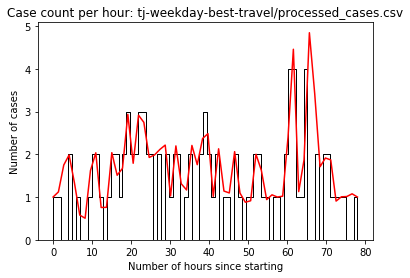

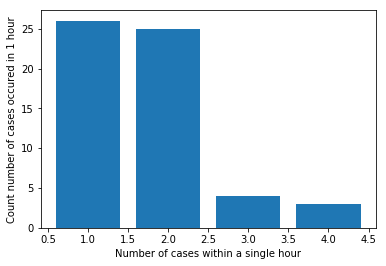

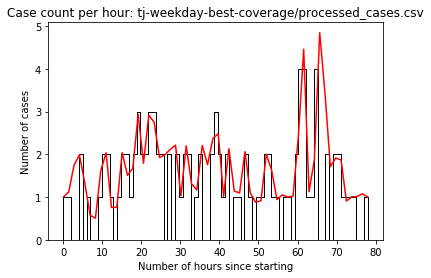

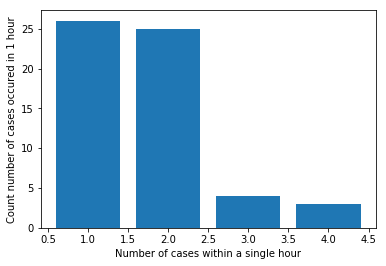

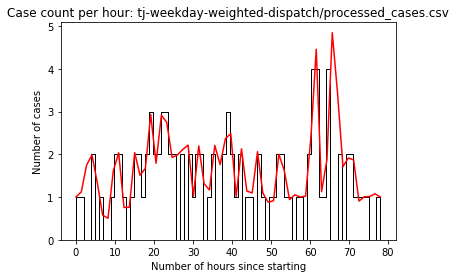

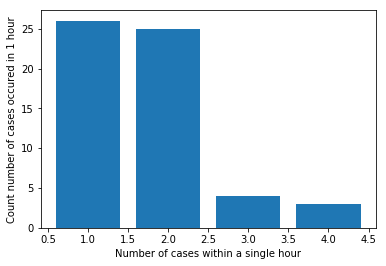

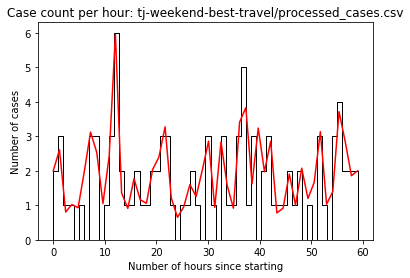

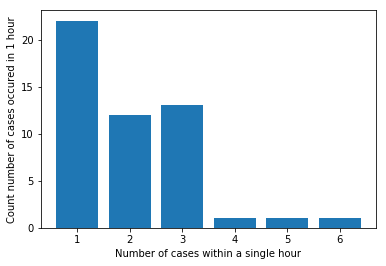

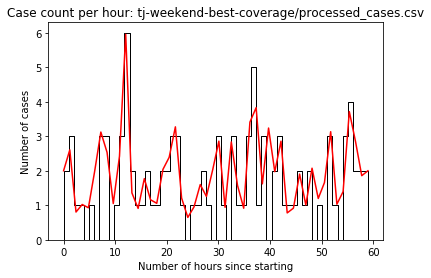

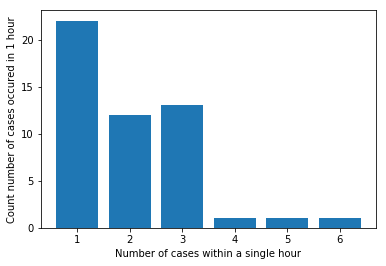

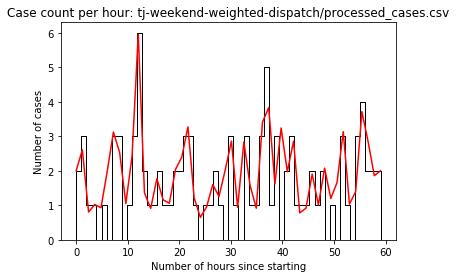

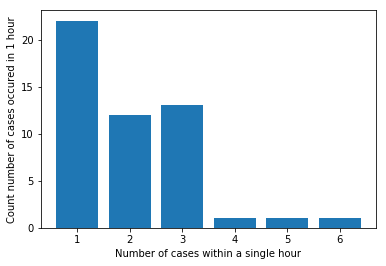

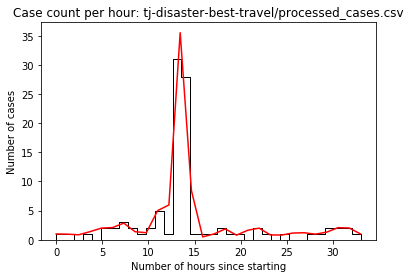

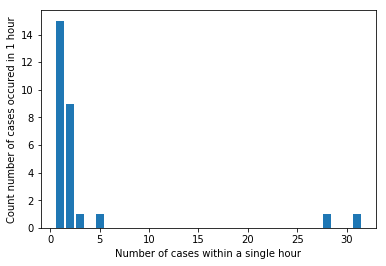

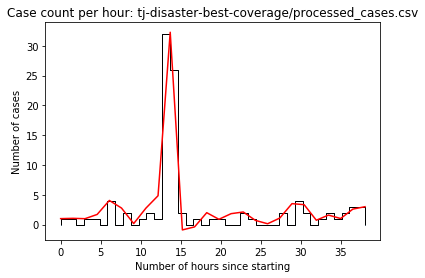

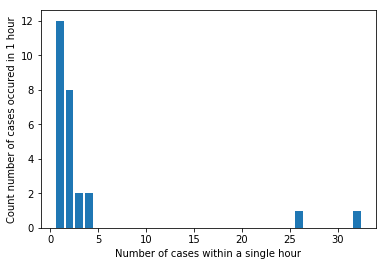

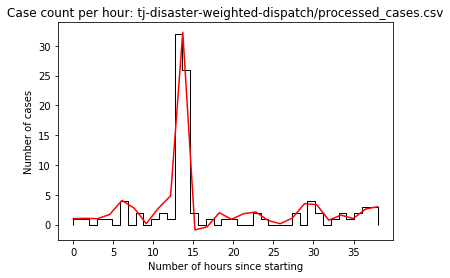

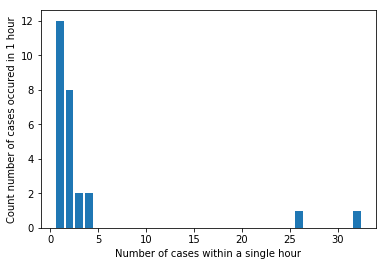

In [11]:
# Define the functions necessary to accumulate each set of case datetimes 
# in order to bin them into histographic distributions.

# Draw the histogram for each scenario, before drawing a histogram for all scenarios

# processed cases for each simulation 
cases = {k:v for k,v in dataset.items() if "processed_cases" in k}
# for k in cases.keys(): print(k)

    
def plot_histogram_basic(processed_cases, name):
    """
    For each list of processed cases, draw the histogram distribution of cases per hour.
    """
    assert isinstance(processed_cases, pandas.core.frame.DataFrame)
    assert isinstance(name, str)
    
    # Logic towards the histogram 
    dates = [datetime.strptime(arr[1], '%Y-%m-%d %H:%M:%S.%f').replace(
        minute=0, second=0, microsecond=0) for arr in processed_cases.values]
    
    first = dates[0]
    deltas = [(date-first).total_seconds()/3600 for date in dates]
    
    c = Counter(deltas)
    sum(c.values())

    l = list(deltas)

    # Logic towards the smooth histogram
    smooth_xs = np.linspace(int(min(c.keys())), int(max(c.keys())), len(c.keys()))
    spl = make_interp_spline(list(c.keys()), list(c.values()), k=3)
    smooth_ys = spl(smooth_xs)
    
    
    # Draw the blocky histogram
    figure_title = "Case count per hour: " + name + ""
#     plt.figure(figure_title)
    plt.title(figure_title)
    ys, xs, patches = plt.hist(deltas, bins=int((max(deltas)+1)/1), histtype='step')
    plt.xlabel("Number of hours since starting"); plt.ylabel('Number of cases')

    # Draw the smoothed histogram
    plt.hist(deltas, bins=int((max(deltas)+1)), histtype='step', color='black')
    plt.xlabel("Number of hours since starting"); plt.ylabel('Number of cases')
    # plt.ylim(0,10)
    plt.plot(smooth_xs, smooth_ys, '-', color='red')
    
    plt.show()
    
    
    # The number of cases started within a single hour 
    hours_counted = Counter(list(c.values()))
    
    plt.figure('Number of times each number of cases per hour occurred')
    plt.bar(hours_counted.keys(), hours_counted.values())
    plt.xlabel('Number of cases within a single hour')
    plt.ylabel('Count number of cases occured in 1 hour')
    plt.show()
    return 



# Draw each processed cases' case count. COMMENT OUT WHEN NOT NEEDED.
for name, processed_cases in cases.items():
    plot_histogram_basic(processed_cases, name) 

# REACHING EMERGENCY POINTS WITHIN TIME LIMIT

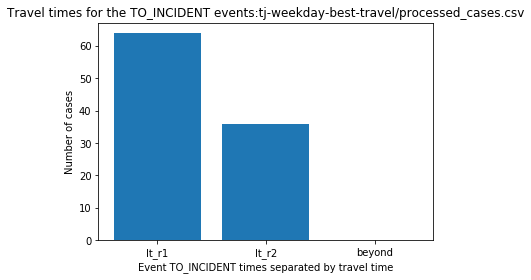

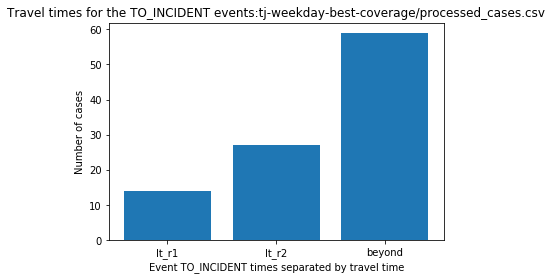

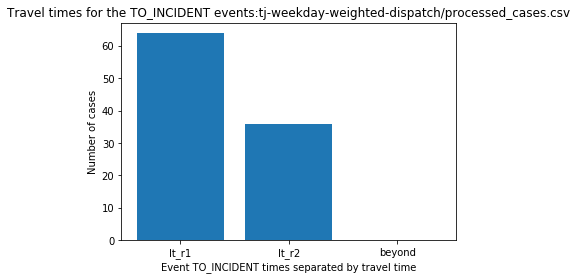

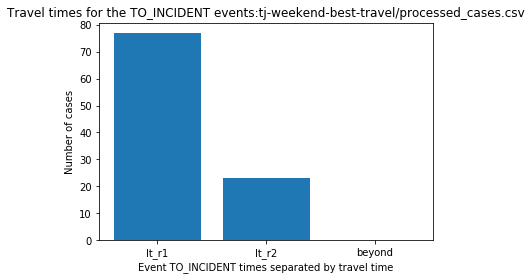

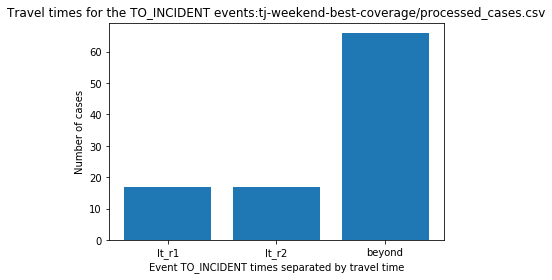

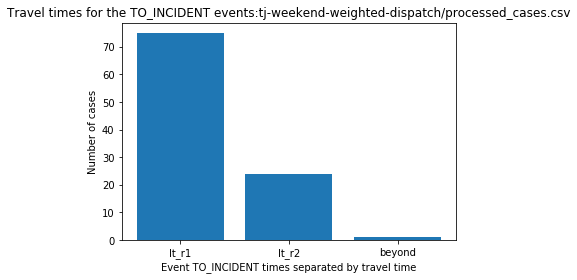

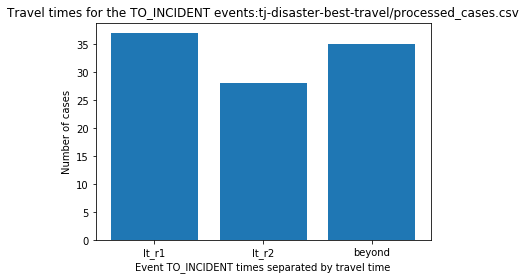

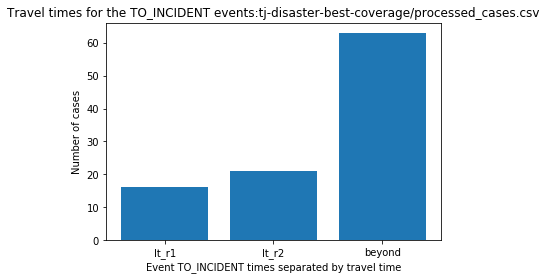

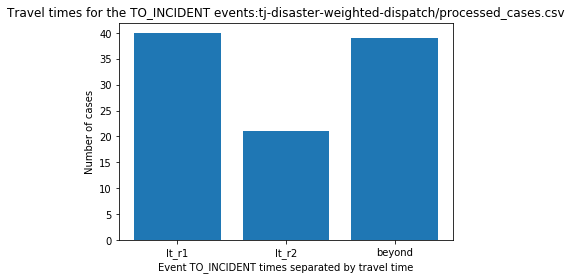

In [12]:
# to incident durations

def plot_travel_times_basic(processed_cases, name):
    
    assert isinstance(processed_cases, pandas.core.frame.DataFrame)
    assert isinstance(name, str)
    
    # Logic for counting cases reached within some time. 
    durations = [pandas.to_timedelta(array[7]) for array in processed_cases.values]
    r1 = timedelta(minutes=10)
    r2 = timedelta(minutes=14)
    
    times = {
    'lt_r1' : list(filter(lambda t: t <  r1, durations)),
    'lt_r2' : list(filter(lambda t: t <  r2 and t >= r1, durations)),
    'beyond': list(filter(lambda t: t >= r2, durations)),
    }

    counts = {k:len(v) for k,v in times.items()}
    
    # Draw the bar graphs
    plt.bar(counts.keys(), counts.values())
    figure_title = "Travel times for the TO_INCIDENT events:" + name
    plt.title(figure_title)
    plt.xlabel("Event TO_INCIDENT times separated by travel time")
    plt.ylabel('Number of cases')
    plt.show()
    
    
#     return

# Draw each processed cases' travel times. COMMENT OUT WHEN NOT NEEDED.
for name, processed_cases in cases.items():
    plot_travel_times_basic(processed_cases, name) 


# COVERAGE FOR EACH SIMULATION

True


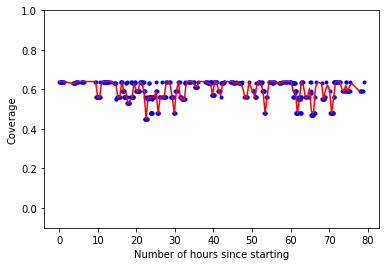

True


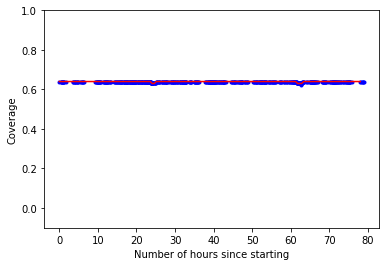

True


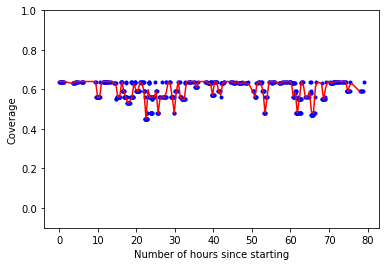

True


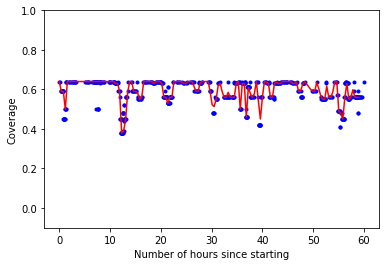

True


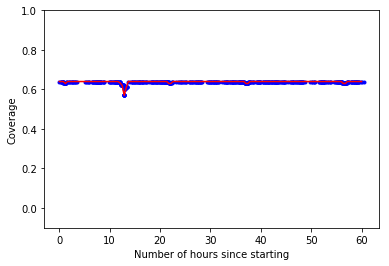

True


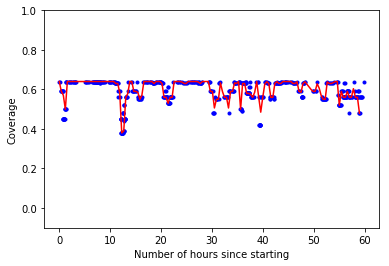

True


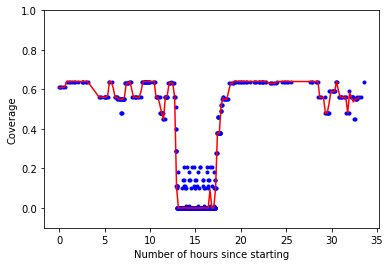

True


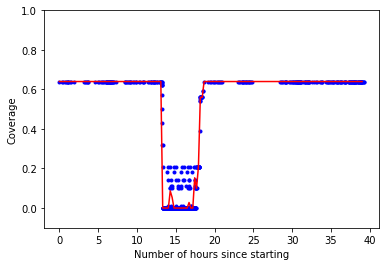

True


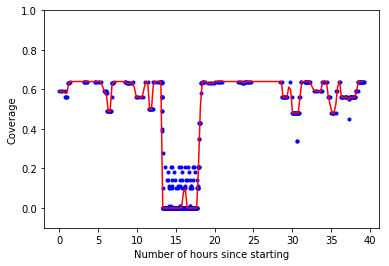

In [18]:
metrics = {k:v for k,v in dataset.items() if "metrics" in k}

def draw_coverage_basic(metrics, name):

    coverages = [(pandas.to_datetime(arr[0]), float(arr[1])) for arr in metrics.values]
    coverages.sort()

    xs = [cov[0] for cov in coverages]
    ys = [cov[1] for cov in coverages]

    first = xs[0]
    xs = [(date-first).total_seconds()/3600 for date in xs]

    print(all([xs[i] <= xs[i+1] for i in range(len(xs)-1)]))

    # Smoothed the original
    smooth_xs = np.linspace(int(min(xs)), int(max(xs)), len(xs)//4)

    spl = make_interp_spline(xs, ys, k=1)
    smooth_ys = spl(smooth_xs)


    plt.figure("Coverages over time ")
    plt.ylim(-0.1, 1.0)
    plt.xlabel("Number of hours since starting"); plt.ylabel('Coverage')

    plt.plot(xs, ys, 'b.' )
    plt.plot(smooth_xs, smooth_ys, '-', color='red')

    plt.show()

for name, metric in metrics.items(): 
    draw_coverage_basic(metric, name)